<H1> CSCA 5642 - Final Project

<H2>Mental Health Sentiment Analysis </H2>

In this project, I aim to create a Recurrent Neural Network to analyse a person's statements to analyse their mental health. I got the dataset from Kaggle and it compiles data from various multiple sources.

Dataset link: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/data

Github link: https://github.com/arshit3005/CSCA-5642-assignments.git

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from keras import layers, optimizers
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, Dropout, TextVectorization, GRU
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
df=pd.read_csv('Combined Data.csv')

In [3]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df=df[['statement','status']]

<H1>EDA</H1>

First, I'm going to check if the dataset contains any duplicate statements or any null rows

In [5]:
df['statement'].duplicated().sum()

1969

In [6]:
df=df.drop_duplicates(subset=['statement'])

In [7]:
df['statement'].duplicated().sum()

0

In [8]:
df['statement'].isna().any()

True

In [9]:
sum(df['statement'].isna())

1

In [10]:
df.dropna(inplace=True)

In [11]:
df['statement'].isna().any()

False

As we can see, the dataset had both duplicates and nulls and now have been removed.

Now that we can have cleaned up dataset. We can dig a bit further. Given we're going to be doing a NLP task, we would need to preprocess our text. For that, we're going to apply a few standard operations.

In [12]:
def text_preprocessing(text):
  stop_words=nltk.corpus.stopwords.words('english')

  text=text.str.lower() #lower case words
  text=text.apply(lambda doc: re.sub(r'[^\w\s]+', '', doc)) # remove punctuation
  text=text.apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)])) # remove stop words
  text=text.apply(lambda doc: re.sub(' +', ' ', doc)) # remove extra white spaces

  return text

In [13]:
df['statement']=text_preprocessing(df['statement'])

Now let us check the distribution of our dataset and see how many samples we have for each category

In [14]:
df['status'].value_counts()

,count
status,
Normal,16039
Depression,15087
Suicidal,10641
Anxiety,3617
Bipolar,2501
Stress,2293
Personality disorder,895


Text(0, 0.5, 'Count')

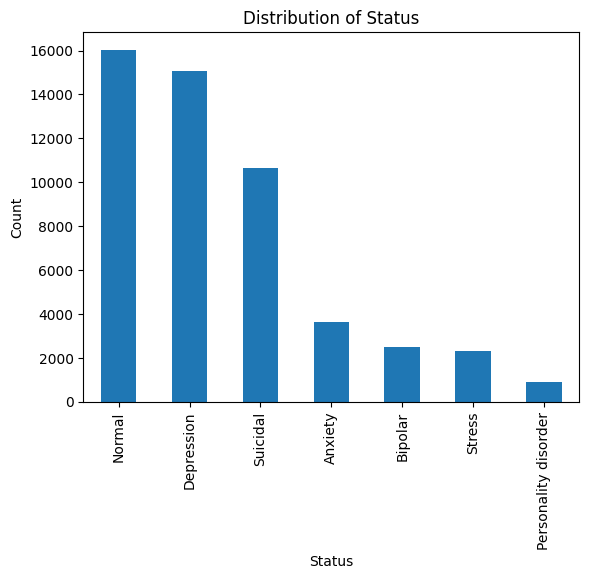

In [15]:
df['status'].value_counts().plot.bar()
plt.title('Distribution of Status')
plt.xlabel('Status')
plt.ylabel('Count')

We can clearly see that there is a big imbalance in our dataset. Normal, Depression and Suicidal categories occur way more than the rest. In fact, Anxiety is 3 times less than Suicidal! Now given such a huge imbalance, I choose to select only the top 3 categories to train our model as our model won't be able to properly classify the underrepresented categories

In [16]:
df=df[df['status'].isin(['Normal','Depression','Suicidal'])]

In [17]:
df['status'].value_counts()

,count
status,
Normal,16039
Depression,15087
Suicidal,10641


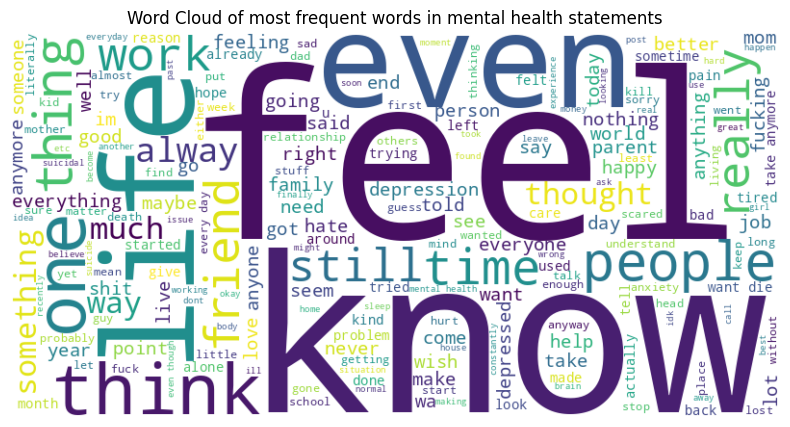

In [18]:
text=' '.join(df['statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of most frequent words in mental health statements')
plt.show()

<H1> Model preparation and training </H1>

Now that we are done exploring and cleaning our dataset. We can now proceed to prepare it for our model. First, we would need to encode our categories to numeric format.

In [19]:
status_mapping = {
    'Normal': 0,
    'Depression': 1,
    'Suicidal': 2,
}
df['encoded_status']=df['status'].map(status_mapping)

y = df['encoded_status']

Next, we would need to tokenize our text. In essence, convert it to numerical format so that it can be passed to our model. Now there are multiple ways to do it like Word2Vec, Glove, TF-IDF. But instead of using any of those, I choose to use the tokenizer provided by the keras library instead as it would be the easiest format for our model to understand.

In [20]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df['statement'])

In [21]:
sequences=tokenizer.texts_to_sequences(df['statement'])

Once tokenizer is fit on the data, we would need to pad our sentences to ensure all sentences are the same length and it forms a proper matrix for our neural network.

In [22]:
max_seq_len=max(len(seq) for seq in sequences)
X=pad_sequences(sequences,maxlen=max_seq_len)

Now let's split up our data into training, validation and test set

In [23]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2) #carve out 20% for test set

X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1) #further split into 90% training and 10 % validation set

In [24]:
print('No. of samples in training set:',len(X_train))
print('No. of samples in validation set:',len(X_val))
print('No. of samples in test set:',len(X_test))

No. of samples in training set: 30071
No. of samples in validation set: 3342


In [25]:
words=len(tokenizer.word_index)+1

Now given that this is a NLP task, I choose to proceed with a rather simple Recurrent Neural network. Given the length of our sentences is rather small, I don't use GRU or LSTM. However, for further iterations, they can be explored.

In [31]:
rnn_model = Sequential([
    Embedding(words,300, input_length=max_seq_len),
    SimpleRNN(128,return_sequences=True,kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    SimpleRNN(64,),
    Dense(3,activation='softmax',kernel_regularizer=l2(0.001))
])

In [32]:
optimizer=Adam(learning_rate=0.001)

In [33]:
rnn_model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [53]:
rnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 3780, 300)      │    20,622,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 3780, 128)      │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3780, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,068,379 (236.77 MB)

 Trainable params: 20,689,459 (78.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,378,920 (157.85 MB)

In [35]:
rnn_model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=1,batch_size=64)

470/470 ━━━━━━━━━━━━━━━━━━━━ 5791s 12s/step - accuracy: 0.6754 - loss: 0.8332 - val_accuracy: 0.7750 - val_loss: 0.5606


In [37]:
y_pred=rnn_model.predict(X_test)

262/262 ━━━━━━━━━━━━━━━━━━━━ 249s 948ms/step


In [44]:
y_pred

array([[0.94996464, 0.01510307, 0.03493225],
       [0.00898408, 0.5804444 , 0.41057155],
       [0.9606584 , 0.01637265, 0.0229689 ],
       ...,
       [0.006488  , 0.5721411 , 0.42137086],
       [0.00379151, 0.5522894 , 0.44391903],
       [0.00871284, 0.50711095, 0.4841762 ]], dtype=float32)

In [47]:
predictions=[]
for i in y_pred:
  predictions.append(np.argmax(i))

In [49]:
accuracy=accuracy_score(y_test,predictions)
print('Accuracy on Test Set:',accuracy)

Accuracy on Test Set: 0.7734019631314341


In [52]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3218
           1       0.71      0.71      0.71      3013
           2       0.62      0.63      0.62      2123

    accuracy                           0.77      8354
   macro avg       0.76      0.76      0.76      8354
weighted avg       0.77      0.77      0.77      8354



From the above 2 cells, we can see that our model had an test accuracy of 77% which seems to be quite good given how simple the model was.

<H1> Final Conclusion </H1>

For this assignment, i trained a RNN sentences which classified the person's mental state. While the model took too long to train and was computationally expensive due to the nature of our word embeddings, we still got a good validation and test score of >75% despite training accuracy of just 67%. It could be pure chance and our model might still have underfit the data, but seems a good enough score as a starting point.